In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from KDEpy import FFTKDE
from tqdm.auto import tqdm
from math import ceil
import itertools
import scipy
from fast_histogram import histogram2d
import colorcet as cc
import matplotlib.colors as colors
import h5py
import io
import cloudpickle as cpl
from collections import defaultdict
import os
from joblib import Parallel, delayed

lmap = lambda func, *iterable: list(map(func, *iterable))

In [2]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

cmap = LinearSegmentedColormap.from_list("CyanOrange", ["C0", "white", "C1"])
mpl.colormaps.register(cmap)

In [3]:
dataset_path = "/data/output/20220226_robustness/dataset.h5"

In [12]:
with h5py.File(dataset_path, "r") as f:
    sparse_ids = set(f["sparse_filter_ids"][:])

In [15]:
df_meta = pd.read_hdf(dataset_path, "meta")
df_meta["filter_count"] = df_meta["filter_ids"].apply(lambda s: len(np.arange(int(s.split(":")[0]), 1 + int(s.split(":")[1]))))
df_meta["clean_filter_count"] = df_meta["filter_ids"].apply(lambda s: len(list(set(np.arange(int(s.split(":")[0]), 1 + int(s.split(":")[1]))) - sparse_ids)))
df_meta.Robust = df_meta.Robust.apply(bool)

df_meta_sparse = pd.read_hdf(dataset_path, "meta_sparsity")
df_meta_pca = pd.read_hdf(dataset_path, "meta_pca")
df_meta_ortho = pd.read_hdf(dataset_path, "meta_ortho")
df_meta = pd.concat([df_meta, df_meta_sparse, df_meta_pca, df_meta_ortho], axis=1)

In [16]:
df_meta

layer_depth  in_channels  \
model_id conv_depth conv_depth_norm layer_id                             
0        0          0.000000        0                   0            3   
         1          0.062500        1                   3           64   
         3          0.187500        2                   9           64   
         2          0.125000        3                   5           64   
         5          0.312500        4                  15           64   
...                                                   ...          ...   
118      24         0.800000        26                 70          640   
         29         0.966667        27                 86          640   
         26         0.866667        28                 76          640   
         28         0.933333        29                 82          640   
         30         1.000000        30                 88          640   

                                              out_channels  \
model_id conv_depth conv_depth_norm layer_id                 
0        0          0.000000        0                   64   
         1          0.062500        1                   64   
         3          0.187500        2                   64   
         2          0.125000        3                   64   
         5          0.312500        4                  128   
...                                                    ...   
118      24         0.800000        26                 640   
         29         0.966667        27                 640   
         26         0.866667        28                 640   
         28         0.933333        29                 640   
         30         1.000000        30                 640   

                                                         filter_ids  \
model_id conv_depth conv_depth_norm layer_id                          
0        0          0.000000        0                         0:191   
         1          0.062500        1                      192:4287   
         3          0.187500        2                     4288:8383   
         2          0.125000        3                    8384:12479   
         5          0.312500        4                   12480:20671   
...                                                             ...   
118      24         0.800000        26        1006120592:1006530191   
         29         0.966667        27        1006530192:1006939791   
         26         0.866667        28        1006939792:1007349391   
         28         0.933333        29        1007349392:1007758991   
         30         1.000000        30        1007758992:1008168591   

                                                                                          model  \
model_id conv_depth conv_depth_norm layer_id                                                      
0        0          0.000000        0         hso_normal_training_robustbench_Addepalli2021T...   
         1          0.062500        1         hso_normal_training_robustbench_Addepalli2021T...   
         3          0.187500        2         hso_normal_training_robustbench_Addepalli2021T...   
         2          0.125000        3         hso_normal_training_robustbench_Addepalli2021T...   
         5          0.312500        4         hso_normal_training_robustbench_Addepalli2021T...   
...                                                                                         ...   
118      24         0.800000        26             robustbench_Zhang2020Attacks_cifar10_linf_13   
         29         0.966667        27             robustbench_Zhang2020Attacks_cifar10_linf_13   
         26         0.866667        28             robustbench_Zhang2020Attacks_cifar10_linf_13   
         28         0.933333        29             robustbench_Zhang2020Attacks_cifar10_linf_13   
         30         1.000000        30             robustbench_Zhang2020Attacks_cifar10_linf_13   

                                                                

In [17]:
df_pairings = pd.read_csv("robust_vs_normal_pairings.csv", index_col=0)
all_used_model_names = pd.concat([df_pairings.Robust, df_pairings.Normal]).unique()

In [99]:
sparsity_mean = df_meta.groupby("model").apply(lambda group: pd.Series({"result": group["layer_sparse_filters"].sum() / group["layer_num_filters"].sum()}))
df_pairings["sparsity_mean"] = df_pairings.Robust.apply(lambda name: sparsity_mean.loc[name])

entropy_mean = df_meta.groupby("model").apply(lambda group: pd.Series({"result": (group["entropy"] * group["clean_filter_count"]).sum() / group["clean_filter_count"].sum()}))
df_pairings["entropy_mean"] = df_pairings.Robust.apply(lambda name: entropy_mean.loc[name])

ortho_mean = df_meta.groupby("model").apply(lambda group: pd.Series({"result": (group["ortho"] * group["out_channels"]).sum() / group["out_channels"].sum()}))
df_pairings["ortho_mean"] = df_pairings.Robust.apply(lambda name: ortho_mean.loc[name])

In [98]:
sparsity_mean = df_meta[df_meta.index.get_level_values("conv_depth") == 0].groupby("model").apply(lambda group: pd.Series({"result": group["layer_sparse_filters"].sum() / group["layer_num_filters"].sum()}))
df_pairings["sparsity_first"] = df_pairings[df_pairings.Dataset != "imagenet"].Robust.apply(lambda name: sparsity_mean.loc[name])

entropy_mean = df_meta[df_meta.index.get_level_values("conv_depth") == 0].groupby("model").apply(lambda group: pd.Series({"result": (group["entropy"] * group["clean_filter_count"]).sum() / group["clean_filter_count"].sum()}))
df_pairings["entropy_first"] = df_pairings[df_pairings.Dataset != "imagenet"].Robust.apply(lambda name: entropy_mean.loc[name])

ortho_mean = df_meta[df_meta.index.get_level_values("conv_depth") == 0].groupby("model").apply(lambda group: pd.Series({"result": (group["ortho"] * group["out_channels"]).sum() / group["out_channels"].sum()}))
df_pairings["ortho_first"] = df_pairings[df_pairings.Dataset != "imagenet"].Robust.apply(lambda name: ortho_mean.loc[name])

In [33]:
df_pairings["clean_acc"] = df_pairings.Robust.apply(lambda name: df_meta[df_meta.Name == name]["Clean Accuracy"].values[0])
df_pairings["robust_acc"] = df_pairings.Robust.apply(lambda name: df_meta[df_meta.Name == name]["Robust Accuracy"].values[0])

In [48]:
import scipy.stats

In [77]:
df_pairings.groupby(["Dataset"]).apply(lambda group: scipy.stats.spearmanr(group.clean_acc, group.robust_acc)[0])

Dataset
cifar10     0.708046
cifar100    0.460784
imagenet    1.000000
dtype: float64

In [78]:
df_pairings.groupby(["Dataset"]).apply(lambda group: scipy.stats.spearmanr(group.entropy_mean, group.robust_acc)[0])

Dataset
cifar10     0.437959
cifar100    0.129902
imagenet   -0.600000
dtype: float64

In [79]:
df_pairings.groupby(["Dataset"]).apply(lambda group: scipy.stats.spearmanr(group.sparsity_mean, group.robust_acc)[0])

Dataset
cifar10    -0.274286
cifar100   -0.203431
imagenet   -0.100000
dtype: float64

In [ ]:
df_pairings.groupby(["Dataset"]).apply(lambda group: scipy.stats.spearmanr(group.entropy_mean, group.robust_acc)[0])

In [73]:
corr_df = df_pairings.groupby(["Dataset", "Arch"]).Robust.apply(len).to_frame()

In [74]:
corr_df["clean_acc"] = df_pairings.groupby(["Dataset", "Arch"]).apply(lambda group: scipy.stats.spearmanr(group.clean_acc, group.robust_acc)[0])
corr_df["entropy_mean"] = df_pairings.groupby(["Dataset", "Arch"]).apply(lambda group: scipy.stats.spearmanr(group.entropy_mean, group.robust_acc)[0])
corr_df["sparsity_mean"] = df_pairings.groupby(["Dataset", "Arch"]).apply(lambda group: scipy.stats.spearmanr(group.sparsity_mean, group.robust_acc)[0])
corr_df["ortho_mean"] = df_pairings.groupby(["Dataset", "Arch"]).apply(lambda group: scipy.stats.spearmanr(group.ortho_mean, group.robust_acc)[0])

In [75]:
corr_df[corr_df.Robust > 2]

Robust  clean_acc  entropy_mean  sparsity_mean  \
Dataset  Arch                                                               
cifar10  PreActResNet-18        6   0.885714      1.000000       0.257143   
         WideResNet-28-10      11   0.113896      0.618182      -0.745455   
         WideResNet-34-10      12  -0.031524      0.559441      -0.356643   
         WideResNet-34-20       5   0.200000     -0.300000      -0.200000   
         WideResNet-70-16       5   0.900000     -0.100000       0.500000   
cifar100 PreActResNet-18        4   0.400000      0.800000      -0.800000   
         WideResNet-34-10       7   0.142857     -0.214286       0.000000   
         WideResNet-70-16       3   1.000000     -0.500000       1.000000   
imagenet ResNet-50              3   1.000000     -0.500000       0.500000   

                           ortho_mean  
Dataset  Arch                          
cifar10  PreActResNet-18    -1.000000  
         WideResNet-28-10   -0.127273  
         WideResNet-34-10   -0.741259  
         WideResNet-34-20    0.300000  
         WideResNet-70-16   -0.300000  
cifar100 PreActResNet-18    -1.000000  
         WideResNet-34-10   -0.214286  
         WideResNet-70-16   -1.000000  
imagenet ResNet-50          -1.000000

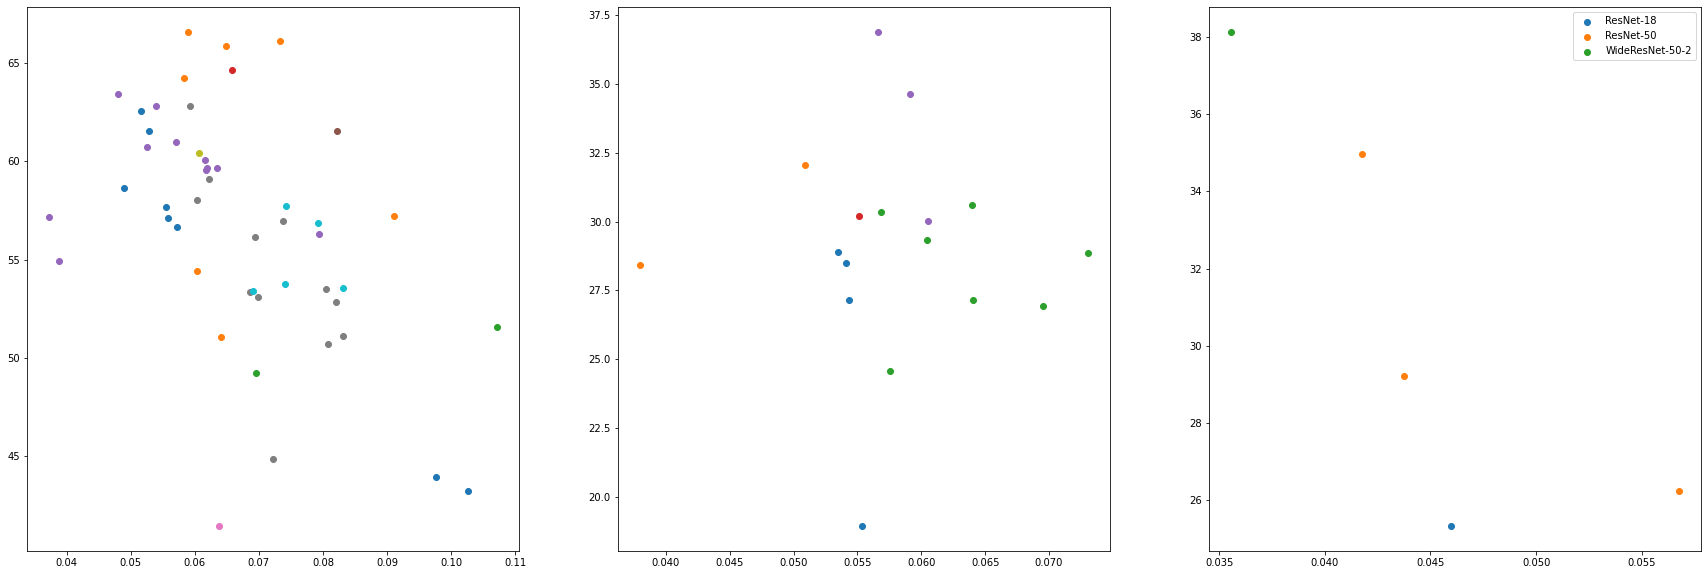

In [101]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
for i, dataset in enumerate(df_pairings.Dataset.unique()):
    df_pairings[df_pairings.Dataset == dataset].groupby("Arch").apply(lambda group: ax[i].scatter(group.ortho_mean, group.robust_acc, label=group.name))
plt.legend()